# Seminar. Variational Autoencoders

Author: Kolesov Alexander

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data as data

from typing import Tuple
from collections import defaultdict

In [2]:
assert torch.cuda.is_available()
DEVICE = 'cuda'
USE_CUDA=True

## 1. Variational inference

#### 1.1 Problem statement

$\textbf{Data}$: $X =  \{x_{1},...,x_{n}\} $ are independent samples $D$-dimensional samples
$\textbf{Task}$: We solve the task of generative modeling $p(X|\Theta)$, where $\Theta$ are parameters of the model.

While we use this model, one can set optimization problem like $\textbf{MLE-problem}$:

$$ \Theta^{*} = \arg \max_{\Theta}  p(X|\Theta)$$

However, one can consider our model like model with $d$-dimensional latent (hidden) variables $Z$. Thus, having assumed existence of latent codes of our model, we can represent of likelihood as follows:

$$ p(X|\Theta)  = p(X|Z,\Theta) p(Z|\Theta) $$

<img src="https://i.pinimg.com/originals/d2/c0/c9/d2c0c9e9c4c5b2e436815f773c47d5e5.jpg" width=600 height=100 />

$\textbf{Importantly}$, we do this step because we sure, that introduced models might be easily parameterized. For example, like normal distributions:

- $p(X|Z,\Theta) = \mathcal{N}(X| \mu(Z,\Theta), \Sigma^{-1}(Z, \Theta))$

- $p(Z|\Theta) = \mathcal{N}(Z| \mu(\Theta), \Sigma^{-1}(\Theta))$

Then, our $\textbf{MLE}$-problem is the following:

$$ \Theta^{*} = \arg\max_{\Theta}\prod_{i=1}^{n} p(x_{i}|\Theta)=  \arg\max_{\Theta}\prod_{i=1}^{n} \int_{\mathbb{R}^{d}} p(x_{i}|Z, \Theta)p(Z|\Theta)dZ $$

#### 1.2 Naive approach

Undoubtedly, this problem might be solved through Monte-Carlo simulation:

$$ \int p(x_{i}|Z,\Theta)p(Z|\Theta) dZ = \mathbb{E}_{\hat{Z} \sim p(Z|\Theta)} p(x_{i}|\hat{Z},\Theta) = \frac{1}{K}\sum_{k=1}^{K} p(x_{i}|\hat{Z}_{k},\Theta) $$

<img src="https://github.com/r-isachenko/2022-2023-DGM-MIPT-course/blob/main/seminars/seminar3/pics/lvm_diagram.png?raw=true">

$\textbf{Challenge}$: The curse of dimensionality. Namely, we cannot properly cover whole space of $p(Z|\Theta)$ due to high dimension of the latent code. One can avoid this problem with sampleing more samples, however this amount will grow with increasing of dimensionality of latent code. Thus, to cover the space properly., the number of samples grows exponentially with respect to dimensionality of $Z$. Finally, we cannot make accurate estimation for the integral.

$\textbf{Another explanation}$ ...

#### 1.3 EM-algorithm

Since:

$$ p(x_{i}|\Theta) = \int_{\mathbb{R}^{d}}p(x_{i}|Z,\Theta)p(Z|\Theta)dZ $$

Then, we can consider this problem like problem for $\textbf{EM}$-algorithm. As far as we know^ $\textbf{E}$-step might be solved by two ways:

- Accurate Bayesian inference
- Mean-field approximation

In $\textbf{E}$-step, we have the following tractable integral that we cannot calculate and as a consequence of that we cannot perform Accurate Bayesian inference.

$$ q(Z|x_{i},\Theta) = \frac{p(x_{i}|Z,\Theta) p(Z|\Theta)}{\int_{\mathbb{R}^{d}}p(x_{i}|Z,\Theta) p(Z|\Theta)dZ}$$

Mean-field is sufficnetly difficult for high dimensional latent codes.



#### 1.4 Variational Inference

Then, we move on the Variational Inference:

$$ \sum_{i=1}^{n} \log p(x_{i}|\Theta) = \sum_{i=1}^{n} \log p(x_{i}|\Theta) \int_{\mathbb{R}^{d}}q(Z)dZ =  
 \sum_{i=1}^{n} \int_{\mathbb{R}^{d}}  \log p(x_{i}|\Theta) q(Z)dZ$$

$$\sum_{i=1}^{n} \int_{\mathbb{R}^{d}}  \log p(x_{i}|\Theta) q(Z)dZ  =  \sum_{i=1}^{n} \int_{\mathbb{R}^{d}} q(Z)\log\frac{p(x_{i},Z|\Theta)q(Z)}{p(Z|\Theta,x_{i})q(Z)}dZ = $$

$$ = \sum_{i=1}^{n} \int q(Z)\log\frac{p(x_{i},Z|\Theta)}{q(Z)}dZ + \sum_{i=1}^{n}\int q(Z)\log \frac{q(Z)}{p(Z|x_{i},\Theta)}dZ$$

The last term is $\textbf{KL}$-divergence between our prior knowledge and observed posterior distribution. The main properties of this disctance are:

- $KL \geq 0$
- $KL( \mathbb{P}|| \mathbb{Q}) = 0$ , if $\mathbb{P}=\mathbb{Q}$

Finally, we get $\textbf{ELBO}$:

$$ \sum_{i=1}^{n} \log p(x_{i}|\Theta) \geq \sum_{i=1}^{n} \int q(Z)\log\frac{p(x_{i},Z|\Theta)}{q(Z)}dZ$$

It is worth noticing, that $\textbf{ELBO}$ has the same formula for optimization like for VAE. We will held maximization for parameters $\Theta$ and latent distribution $q(Z)$ like in EM-algorithm. Nonetheless, the main distinguish is that likelihood and prior will be constrained by normal distribution during the $\textbf{E}$-step.

Thus, we have two models:

-  $p(x_{i},Z|\Theta)$ is normal distribution parametrized by NN with parameters $\Theta$.
-  $q(Z|x_{i},\phi)$ is normal distribution parameterized by NN with parameters $\phi$.

Undoubtedly, we make more constraints , than we had with acurrate and mean-field solution of EM.

$\textbf{Our problem with Variational inference}$:

$$ \sum_{i=1}^{n} \int_{\mathbb{R}^{d}} q(Z|x_{i},\phi) \log\frac{p(x_{i},Z|\Theta)}{q(Z|x_{i},\phi)}dZ \to \max_{\Theta,\phi}$$

## 2. Variational Auto Encoders (VAE)

Now, we make assumption about $\textbf{non-linear}$ dependence between $X$ and $Z$. Then:

#### 2.1 like M-step:

our task is maximization during M-step:

$$\sum_{i=1}^{n} \mathbb{E}_{q(Z|x_{i},\phi)} \log p(x_{i},Z|\Theta) \to \max_{\Theta} $$

Then, to calculate this, we need in:

- model $q(Z|x_{i},\phi)$ should give us samples
- logarithm of $ p(x_{i},Z|\Theta)$

Then we introduce model $ p(x_{i},Z|\Theta)$ as:

$$ p(x_{i},Z|\Theta) = \mathcal{N}(x_{i}| \mu(z_{i},\Theta) , \sigma^{2}(z_{i},\Theta)I)*\mathcal{N}(z_{i}|0,I) $$
$$p(x_{i},Z|\Theta) = \prod_{j=1}^{D}\mathcal{N}(x_{ij}| \mu_{j}(z_{i},\Theta) , \sigma_{j}^{2}(z_{i},\Theta))*\mathcal{N}(z_{i}|0,I) $$

Thus, the first multiplier is the $\textbf{decoder}$ :

- takes $d$-dimensional latent code
- outputs 2$D$-dimensional vector, where the $D$-first are means for the corresponding pixel of image, while the second are variances.


Also, we introduce the following model with ability of sampling latent codes from data sample.

$$ q(z|x_{i},\phi) = \prod_{j=1}^{d} \mathcal{N}(z_{j}|m_{j}(x_{i},\phi),s_{j}^{2}(x_{i},\phi))$$

This model is the $\textbf{encoder}$

- takes $D$-dimensional sample from data
- outputs 2$d$-dimensional vector, where the $d$-first are means for the corresponding latent code, while the second are variances.

It is worth noticing, that the  posterior distribution $q(z|x_{i},\phi)$. is multiplication of 1-dimensional normal distributions.

#### 2.2 like E-step:


During the $\textbf{E}$-step, we maximize by parameters of encoder:

However, we know, that the maximization of ELBO corresponds to the minimization of $\textbf{KL}$-divergence between prior and current posterior (encoder):

$$ KL(q(z_{i}|x_{i},\phi) || p(z)) \to \min_{\phi}$$

Yet another reason for choosing normal distribution for $q(z_{i}|x_{i},\phi)$  is the existence closed form of KL-divergence between gaussian distributions. Thta is why, we pick prior knowledge $p(z)$ as gaussian too.

<img src="https://www.compthree.com/images/blog/ae/vae.png" width=600 height=500/>

## 3. VAE on 2d data


In this task we will implement simple VAE model for 2d gaussian distribution $\mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\Sigma})$.

We will consider two cases:
* 2d univariate distribution (diagonal covariance matrix $\boldsymbol{\Sigma}$);
* 2d multivariate distribution (strictly non-diagonal covariance matrix $\boldsymbol{\Sigma}$).

The goal is to analyze the difference between these two cases and understand why the trained VAE models will behave differently.

### 3.1 Data generation

In [3]:
TICKS_FONT_SIZE = 12
LEGEND_FONT_SIZE = 12
LABEL_FONT_SIZE = 14
TITLE_FONT_SIZE = 16

In [4]:
def visualize_2d_data(
    train_data,test_data,train_labels=None ,
    test_labels=None ):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.set_title("train", fontsize=TITLE_FONT_SIZE)
    ax1.scatter(train_data[:, 0], train_data[:, 1], s=1, c=train_labels)
    ax1.tick_params(labelsize=LABEL_FONT_SIZE)
    ax2.set_title("test", fontsize=TITLE_FONT_SIZE)
    ax2.scatter(test_data[:, 0], test_data[:, 1], s=1, c=test_labels)
    ax2.tick_params(labelsize=LABEL_FONT_SIZE)
    plt.show()

In [5]:
def visualize_2d_samples(data, title, labels=None, xlabel=None, ylabel=None):
    plt.figure(figsize=(5, 5))
    plt.scatter(data[:, 0], data[:, 1], s=1, c=labels)
    plt.title(title, fontsize=TITLE_FONT_SIZE)
    plt.xticks(fontsize=TICKS_FONT_SIZE)
    plt.yticks(fontsize=TICKS_FONT_SIZE)
    if xlabel is not None:
        plt.xlabel(xlabel, fontsize=LABEL_FONT_SIZE)
    if ylabel is not None:
        plt.ylabel(ylabel, fontsize=LABEL_FONT_SIZE)
    plt.show()

In [6]:
def generate_2d_data(count, mode='univariate'):
    assert mode in ['univariate', 'multivariate']
    np.random.seed(42)
    mean = [[2.0, 3.0]]
    sigma = [[3.0, 1.0]]
    if mode == 'univariate':
        rotate = [
            [1.0, 0.0],
            [0.0, 1.0]
        ]
    else:
        rotate = [
            [np.sqrt(2) / 2, np.sqrt(2) / 2],
            [-np.sqrt(2) / 2, np.sqrt(2) / 2]
        ]
    data = mean + (np.random.randn(count, 2) * sigma).dot(rotate)
    data = data.astype('float32')
    split = int(0.7 * count)
    train_data, test_data = data[:split], data[split:]
    return train_data, test_data

In [7]:
def plot_training_curves(train_losses, test_losses, logscale_y=False, logscale_x=False):
    n_train = len(train_losses[list(train_losses.keys())[0]])
    n_test = len(test_losses[list(train_losses.keys())[0]])
    x_train = np.linspace(0, n_test - 1, n_train)
    x_test = np.arange(n_test)

    plt.figure()
    for key, value in train_losses.items():
        plt.plot(x_train, value, label=key + '_train')

    for key, value in test_losses.items():
        plt.plot(x_test, value, label=key + '_test')

    if logscale_y:
        plt.semilogy()

    if logscale_x:
        plt.semilogx()

    plt.legend(fontsize=LEGEND_FONT_SIZE)
    plt.xlabel('Epoch', fontsize=LABEL_FONT_SIZE)
    plt.ylabel('Loss', fontsize=LABEL_FONT_SIZE)
    plt.xticks(fontsize=TICKS_FONT_SIZE)
    plt.yticks(fontsize=TICKS_FONT_SIZE)
    plt.grid()
    plt.show()

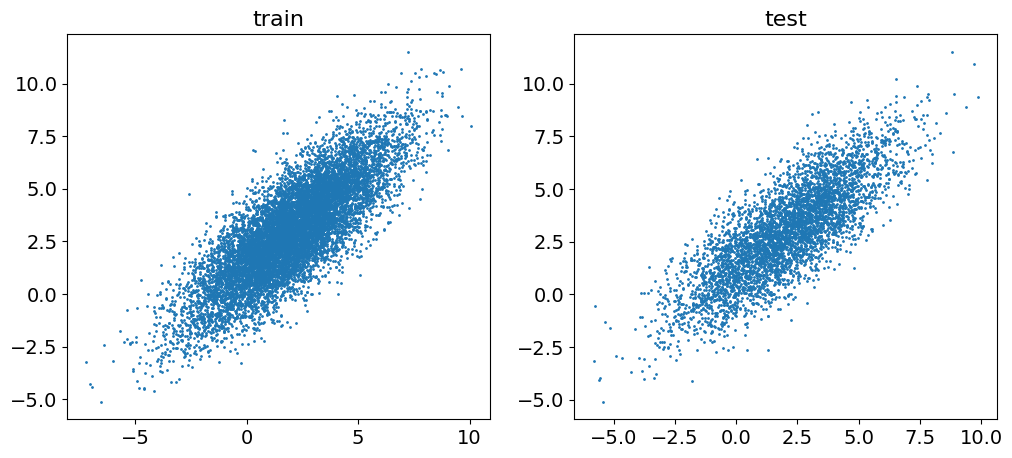

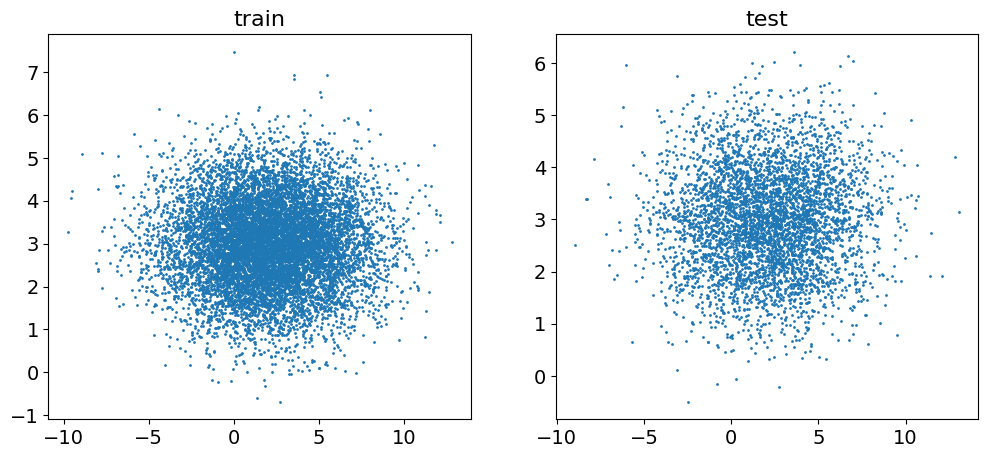

In [8]:
COUNT = 15000

train_data, test_data = generate_2d_data(COUNT, mode='multivariate')
visualize_2d_data(train_data, test_data)

train_data, test_data = generate_2d_data(COUNT, mode='univariate')
visualize_2d_data(train_data, test_data)

The difference of these two cases is the form of covariance matrix $\boldsymbol{\Sigma}$.

In multivariate case the matrix is non-diagonal, in univariate case it is strictly diagonal. As you will see, our VAE model will have absolutely different results for these datasets.

### 3.2 Kl-divergence and log-likelihood

Now it is time to define our model. Our model will have the following structure:

* The latent dimensionality is equal to 2, the same as the data dimensionality ($\mathbf{z} \in \mathbb{R}^2$, $\mathbf{x} \in \mathbb{R}^2$).
* Prior distribution is standard Normal ($p(\mathbf{z}) = \mathcal{N}(0, I)$).
* Variational posterior distribution (or encoder) is $q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi}) = \mathcal{N}(\boldsymbol{\mu}_{\boldsymbol{\phi}}(\mathbf{x}), \boldsymbol{\Sigma}_{\boldsymbol{\phi}}(\mathbf{x}))$. Here $\boldsymbol{\phi}$ denotes all parameters of the encoder neural network.
* Generative distribution (or decoder) is $p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta}) = \mathcal{N}(\boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{z}), \boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z}))$. Here $\boldsymbol{\theta}$ denotes all parameters of the decoder neural network. Please note, that here we will use continuous distribution for our variables $\mathbf{x}$.
* We will consider only diagonal covariance matrices $\boldsymbol{\Sigma}_{\boldsymbol{\phi}}(\mathbf{x})$, $\boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z})$.

Model objective is ELBO:
$$
    \mathcal{L}(\boldsymbol{\phi}, \boldsymbol{\theta}) = \mathbb{E}_{q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi})} \log p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta}) - KL (q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi}) || p(\mathbf{z})).
$$

To make the expectation is independent of parameters $\boldsymbol{\phi}$, we will use reparametrization trick.

To calculate the loss, we should derive
- $\log p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta})$, note that generative distribution is $\mathcal{N}(\boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{z}), \boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z}))$.
- KL between $\mathcal{N}(\boldsymbol{\mu}_{\boldsymbol{\phi}}(\mathbf{x}), \boldsymbol{\Sigma}_{\boldsymbol{\phi}}(\mathbf{x}))$ and $\mathcal{N}(0, I)$.

In [9]:
def get_normal_KL(mean_1, log_std_1, mean_2=None, log_std_2=None):
    """
        This function should return the value of KL(p1 || p2),
        where p1 = Normal(mean_1, exp(log_std_1)), p2 = Normal(mean_2, exp(log_std_2) ** 2).
        If mean_2 and log_std_2 are None values, we will use standard normal distribution.
        Note that we consider the case of diagonal covariance matrix.
    """
    if mean_2 is None:
        mean_2 = torch.zeros_like(mean_1)
    if log_std_2 is None:
        log_std_2 = torch.zeros_like(log_std_1)

    std_1 = torch.exp(log_std_1)
    std_2 = torch.exp(log_std_2)

    mean_1, mean_2 = mean_1.float(), mean_2.float()
    std_1 , std_2  = std_1 .float(), std_2 .float()

    p  = torch.distributions.Normal(mean_1, std_1)
    q  = torch.distributions.Normal(mean_2, std_2)
    kl = torch.distributions.kl_divergence(p, q)

    return kl

In [10]:
def get_normal_nll(x, mean, log_std):
    """
        This function should return the negative log likelihood log p(x),
        where p(x) = Normal(x | mean, exp(log_std) ** 2).
        Note that we consider the case of diagonal covariance matrix.
    """
    # ====
    mean = mean              .float()
    std  = torch.exp(log_std).float()

    #if (mean.dim() == 0) and (std.dim() == 0):
    prob = torch.distributions.Normal(mean, std)
    #else:
    #    scale_tril=torch.diag(std)
    #    prob = torch.distributions.MultivariateNormal(mean, scale_tril=scale_tril)

    nnl = -prob.log_prob(x)
    return nnl

### 3.3 VAE

We will use simple fully connected dense networks for encoder and decoder.

In [11]:
class FullyConnectedMLP(nn.Module):
    def __init__(self, input_shape, hiddens, output_shape):
        assert isinstance(hiddens, list)
        super().__init__()
        self.input_shape  = (input_shape,)
        self.output_shape = (output_shape,)
        self.hiddens = hiddens

        model = []

        # ====
        # your code
        # stack Dense layers with ReLU activation
        # note: you do not have to add relu after the last dense layer
        # ====
        model.append( nn.Linear(input_shape, hiddens[0]) )
        model.append( nn.ReLU() )

        for i in range( len(hiddens)-1 ):
            model.append( nn.Linear(hiddens[i+0], hiddens[i+1]) )
            model.append( nn.ReLU() )

        model.append( nn.Linear(hiddens[-1], output_shape) )
        self.net = nn.Sequential(*model)

    def forward(self, x):
        # ====
        # your code
        # apply network that was defined in __init__ and return the output
        # ====
        return self.net(x)

In [12]:
class VAE2d(nn.Module):
    def __init__(self, n_in, n_latent, enc_hidden_sizes, dec_hidden_sizes):
        assert isinstance(enc_hidden_sizes, list)
        assert isinstance(dec_hidden_sizes, list)
        super().__init__()
        self.n_latent = n_latent

        # ====
        # your code
        # define encoder and decoder networks
        # the encoder takes n_in elements, has enc_hidden_sizes neurons in hidden layers
        # and outputs 2 * n_latent (n_latent for means, and n_latent for std)
        # the decoder takes n_latent elements, has dec_hidden_sizes neurons in hidden layers
        # and outputs 2 * n_in (n_in for means, and n_in for std)
        # ====
        self.encoder = FullyConnectedMLP(n_in    , enc_hidden_sizes, 2 * n_latent )
        self.decoder = FullyConnectedMLP(n_latent, dec_hidden_sizes, 2 * n_in     )
    def prior(self, n):
        # ====
        # your code
        # return n samples from prior distribution (we use standard normal for prior)
        # ====
        loc   = torch.zeros(self.n_latent)
        scale = torch.ones (self.n_latent)
        p = torch.distributions.Normal(loc, scale)
        prior_s = p.sample_n(n)

        if USE_CUDA:
            prior_s = prior_s.cuda()
        return prior_s

    def forward(self, x):
        # ====
        # your code
        # now you have to return from the model
        # - mu_z - means for variational distribution
        # - mu_x - means for generative distribution
        # - log_std_z - logarithm of std for variational distribution
        # - log_std_x - logarithm of std for generative distribution
        # we use logarithm, since the std is always positive
        # to get std we will exponentiate it to get rid of this constraint

        # 1) mu_z, log_std_z are outputs from the encoder
        # 2) apply reparametrization trick to get z (input of decoder)
        # (do not forget to use self.prior())
        # 3) mu_x, log_std_x are outputs from the decoder
        #    Note: [mu, log_std = decoder(input).chunk(2, dim=1)]

        # ====
        mu_z, log_std_z = self.encoder(x).chunk(2, dim=1)
        z = torch.exp(log_std_z.to('cuda'))*self.prior( x.size(0) ) + mu_z.to('cuda')
        mu_x, log_std_x = self.decoder(z).chunk(2, dim=1)

        return mu_z, log_std_z, mu_x, log_std_x

    def loss(self, x):
        mu_z, log_std_z, mu_x, log_std_x = self(x)
        # ====
        # your code
        # 1) apply model to get mu_z, log_std_z, mu_x, log_std_x
        # 2) compute reconstruction loss using get_normal_nll (it is the first term in ELBO)
        # 3) compute KL loss using get_normal_KL (it is the second term in ELBO)
        # ====
        recon_loss = torch.sum(get_normal_nll( x, mu_x, log_std_x ))
        #kl_loss    = torch.sum(get_normal_KL ( mu_z, log_std_z, mu_x, log_std_x ))
        kl_loss    = torch.sum(get_normal_KL ( mu_z, log_std_z, torch.zeros_like(mu_z), torch.zeros_like(log_std_z) ))


        return {
            'elbo_loss': recon_loss + kl_loss,
            'recon_loss': recon_loss,
            'kl_loss': kl_loss
        }

    def sample(self, n, sample_from_decoder=True):
        z = None
        with torch.no_grad():
            # ====
            # your code
            # to sample from VAE model you have to sample from prior
            # and then apply decoder to prior samples.
            # parameter noise indicates whether to sample from decoder
            # or just use means of generative distribution as samples
            # 1) generate prior samples
            # 2) apply decoder
            # 3) sample from the decoder distribution if sample_from_decoder=True
            # ====
            prior_s = self.prior(n)
            mu_x, log_std_x = self.decoder(prior_s).chunk(2, dim=1)
            if sample_from_decoder:
                z = torch.exp(log_std_x)*prior_s + mu_x
            else:
                z = mu_x
        return z.cpu().numpy()

In [13]:
def solve_task(train_data, test_data, model, batch_size, epochs, lr, use_cuda=True, use_tqdm=False):
    train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

    train_losses, test_losses = train_model(
        model, train_loader, test_loader, epochs=EPOCHS, lr=LR, use_cuda=use_cuda, use_tqdm=use_tqdm, loss_key='elbo_loss'
    )
    samples_noise = model.sample(3000, sample_from_decoder=True)
    samples_nonoise = model.sample(3000, sample_from_decoder=False)

    for key, value in test_losses.items():
        print('{}: {:.4f}'.format(key, value[-1]))

    plot_training_curves(train_losses, test_losses)
    visualize_2d_samples(samples_noise, title='Samples with Decoder Noise')
    visualize_2d_samples(samples_nonoise, title='Samples without Decoder Noise')

In [14]:
# ====
# your code
# choose these parameters (2 hidden layers could be enough for encoder and decoder)
ENC_HIDDEN_SIZES = [20, 20]
DEC_HIDDEN_SIZES = [20, 20]
BATCH_SIZE = 32    # any adequate value
EPOCHS = 20         # < 10
LR = 0.001        # < 1e-2
# ====

COUNT = 10000

In [15]:
from tqdm import tqdm

In [16]:
def train_epoch(
    model: object,
    train_loader: object,
    optimizer: object,
    use_cuda: bool,
    loss_key: str = "total",
) -> defaultdict:
    model.train()

    stats = defaultdict(list)
    for x in tqdm(train_loader):
        if use_cuda:
            x = x.cuda()
        losses = model.loss(x)
        optimizer.zero_grad()
        losses[loss_key].backward()
        optimizer.step()

        for k, v in losses.items():
            stats[k].append(v.item())

    return stats


def eval_model(model: object, data_loader: object, use_cuda: bool) -> defaultdict:
    model.eval()
    stats = defaultdict(float)
    with torch.no_grad():
        for x in data_loader:
            if use_cuda:
                x = x.cuda()
            losses = model.loss(x)
            for k, v in losses.items():
                stats[k] += v.item() * x.shape[0]

        for k in stats.keys():
            stats[k] /= len(data_loader.dataset)
    return stats

In [17]:
def train_model(
    model: object,
    train_loader: object,
    test_loader: object,
    epochs: int,
    lr: float,
    use_tqdm: bool = False,
    use_cuda: bool = False,
    loss_key: str = "total_loss",
) -> Tuple[dict, dict]:
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = defaultdict(list)
    test_losses = defaultdict(list)
    forrange = tqdm(range(epochs)) if use_tqdm else range(epochs)
    if use_cuda:
        model = model.cuda()

    for epoch in forrange:
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, use_cuda, loss_key)
        test_loss = eval_model(model, test_loader, use_cuda)

        for k in train_loss.keys():
            train_losses[k].extend(train_loss[k])
            test_losses[k].append(test_loss[k])
    return dict(train_losses), dict(test_losses)

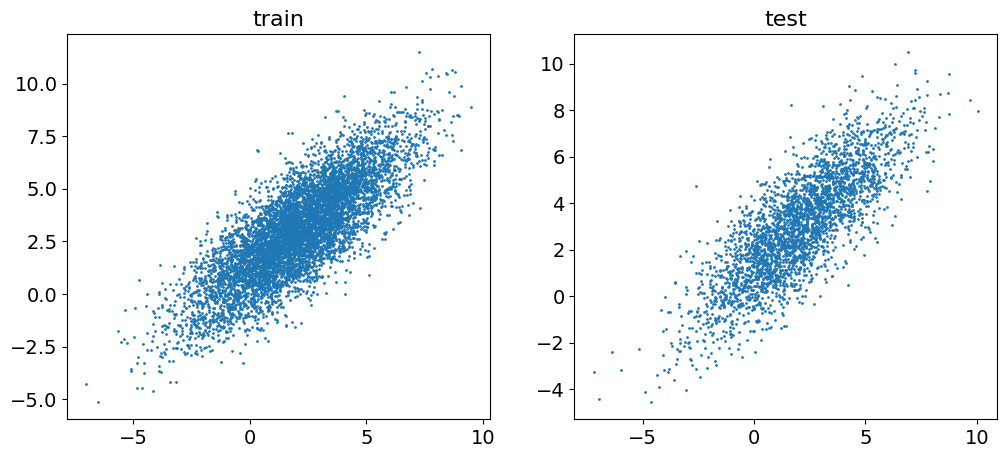

  0%|          | 0/219 [00:00<?, ?it/s]<ipython-input-12-cc548be34b26>:26: FutureWarning: `sample_n(n)` will be deprecated. Use `sample((n,))` instead.
  prior_s = p.sample_n(n)
100%|██████████| 219/219 [00:00<00:00, 243.55it/s]


elbo_loss: 126.6147
recon_loss: 92.0761
kl_loss: 34.5386


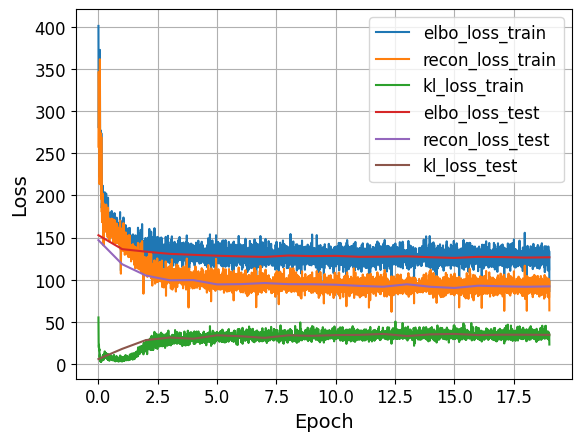

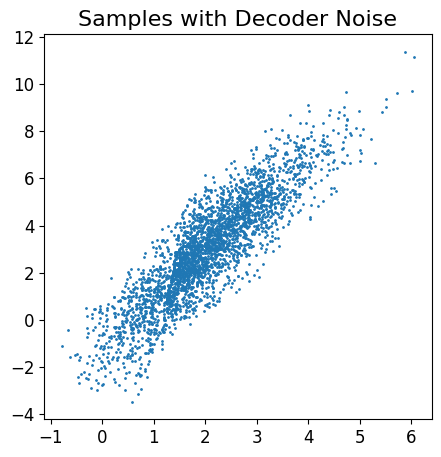

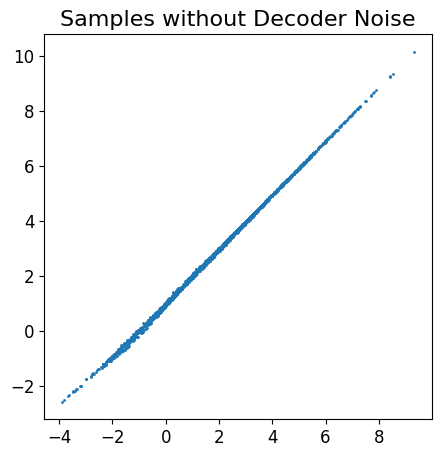

In [18]:
train_data, test_data = generate_2d_data(COUNT, mode='multivariate')
visualize_2d_data(train_data, test_data)

model = VAE2d(2, 2, ENC_HIDDEN_SIZES, DEC_HIDDEN_SIZES).to('cuda')
solve_task(train_data, test_data, model, BATCH_SIZE, EPOCHS, LR, use_cuda=True)

To analyze our models we will use the following function. Look carefully, do not change.

This function calculates the mean $\boldsymbol{\mu}_{\boldsymbol{\phi}}(\mathbf{x})$, and covariances $\boldsymbol{\Sigma}_{\boldsymbol{\phi}}(\mathbf{x})$ of the variational posterior distribution $q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi})$.

In [19]:
def get_latent_stats(model, test_data, use_cuda=True, batch_size=3000):
    batch = next(iter(data.DataLoader(test_data, batch_size=batch_size, shuffle=True)))
    if use_cuda:
        batch = batch.cuda()

    with torch.no_grad():
        mu_z, log_std_z = model(batch)[:2]

    mu_z = mu_z.cpu().numpy()
    std_z = log_std_z.exp().cpu().numpy()

    return mu_z, std_z

In [20]:
# just look at these numbers and read the comments after this task
mu_z, std_z = get_latent_stats(model, test_data, use_cuda=USE_CUDA)

print('mu_z = ', mu_z.mean(axis=0), '+-', mu_z.std(axis=0))
print('std_z = ', std_z.mean(axis=0), '+-', std_z.std(axis=0))

mu_z =  [ 0.00358353 -0.00695307] +- [0.94164646 0.03279162]
std_z =  [0.33994007 1.0068533 ] +- [0.01255434 0.01858365]


<ipython-input-12-cc548be34b26>:26: FutureWarning: `sample_n(n)` will be deprecated. Use `sample((n,))` instead.
  prior_s = p.sample_n(n)


Secondly, we will train the VAE model for univariate gaussian distribution.

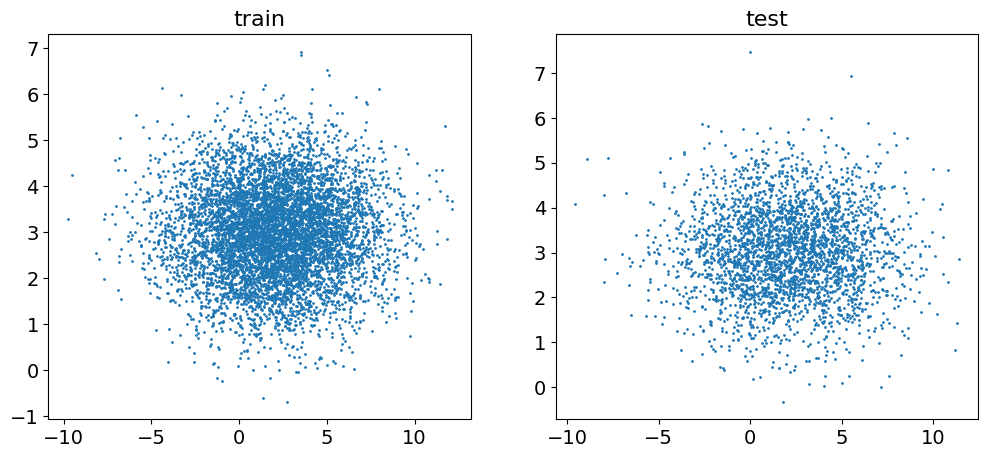

  0%|          | 0/219 [00:00<?, ?it/s]<ipython-input-12-cc548be34b26>:26: FutureWarning: `sample_n(n)` will be deprecated. Use `sample((n,))` instead.
  prior_s = p.sample_n(n)
100%|██████████| 219/219 [00:00<00:00, 250.91it/s]


elbo_loss: 126.3424
recon_loss: 126.1033
kl_loss: 0.2391


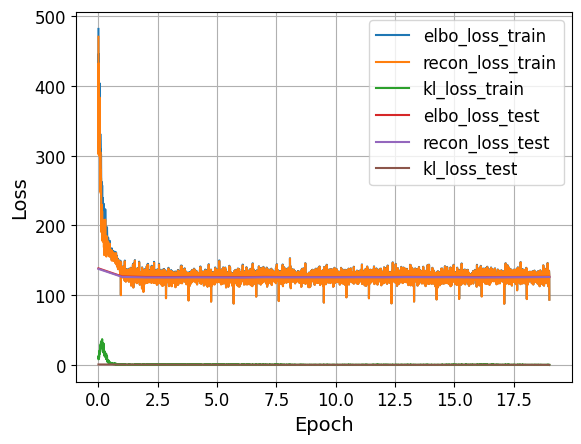

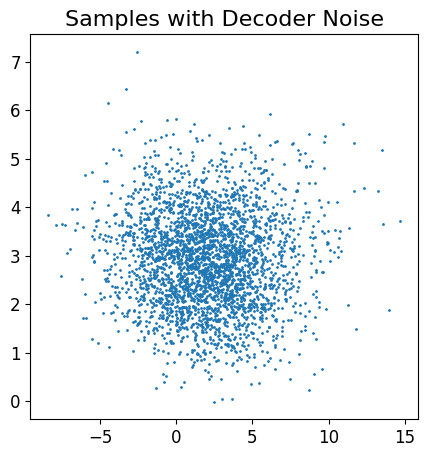

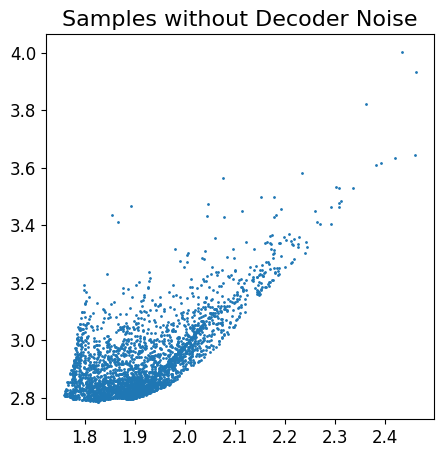

In [21]:
train_data, test_data = generate_2d_data(COUNT, mode='univariate')
visualize_2d_data(train_data, test_data)

model = VAE2d(2, 2, ENC_HIDDEN_SIZES, DEC_HIDDEN_SIZES).cuda()
solve_task(train_data, test_data, model, BATCH_SIZE, EPOCHS, LR, use_cuda=USE_CUDA)

In [22]:
mu_z, std_z = get_latent_stats(model, test_data, use_cuda=USE_CUDA)

print('mu_z = ', mu_z.mean(axis=0), '+-', mu_z.std(axis=0))
print('std_z = ', std_z.mean(axis=0), '+-', std_z.std(axis=0))

mu_z =  [ 0.00109792 -0.0015595 ] +- [0.01724173 0.0275332 ]
std_z =  [1.0057603  0.99934405] +- [0.07049087 0.04469658]


<ipython-input-12-cc548be34b26>:26: FutureWarning: `sample_n(n)` will be deprecated. Use `sample((n,))` instead.
  prior_s = p.sample_n(n)


After training the VAE model on these 2 datasets, have a look at "Samples without Decoder Noise" figures. These figures show the means $\boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{z})$ of the generative distribution $p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta})$. In the case of multivariate gaussian, the means are perfectly aligned with the data distribution.
Otherwise, you have to see the strange figure in the univariate gaussian case . This happens due to so called **posterior collapse** (we will discuss it at the one of our lectures).

To be brief, the reason is the following. Our posterior distribution $p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta}) = \mathcal{N}(\boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{z}), \boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z}))$ is a univariate (covariance matrix is diagonal). Thus, the model does not need latent variable since the data distribution is also univariate. In this case VAE ignores latent variable, cause the model fits the distribution without any information from latent space.

If the decoder ignores latent variable, the second term in ELBO (KL) could be low (variational posterior distribution, which is given by encoder model, is close to prior distribution for each datapoint). In the training curves you have to see that KL loss behaves differently in these two cases.

The mean and std of variational posterior distribution also proves this concept. For the second case you have to see that mean is almost zero and std is almost one.

It is a real problem for generative models and we will discuss later how to overcome it.